In [16]:
import pandas as pd
import numpy as np

import yfinance as yf

import matplotlib.pyplot as plt

from arch import arch_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
data = yf.download("AAPL", start="2018-01-01", end="2025-01-01")
data.to_csv("AAPL.csv")

data.head()

C:\Users\daiya\AppData\Local\Temp\ipykernel_16216\1406508579.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380997,40.390375,39.677740,39.888719,102223600
2018-01-03,40.373959,40.917812,40.310668,40.444285,118071600
2018-01-04,40.561497,40.664642,40.338800,40.446630,89738400
2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
2018-01-08,40.870934,41.166300,40.772474,40.870934,82271200


In [18]:
data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

In [19]:
#normalize
scaler = MinMaxScaler()
data['Return_scaled'] = scaler.fit_transform(data[['Return']])

In [20]:
am = arch_model(data['Return']*100, vol='Garch', p=1, q=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 3464.2534403875857
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3464.0386754799297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3464.0386754799297
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3464.04
Distribution:                  Normal   AIC:                           6936.08
Method:            Maximum Likelihood   BIC:                           6957.97
                                        No. Observations:                 1760
Date:                Sun, Oct 05 2025   Df Residuals:                     1759
Time:       

In [21]:
data['GARCH_vol'] = res.conditional_volatility

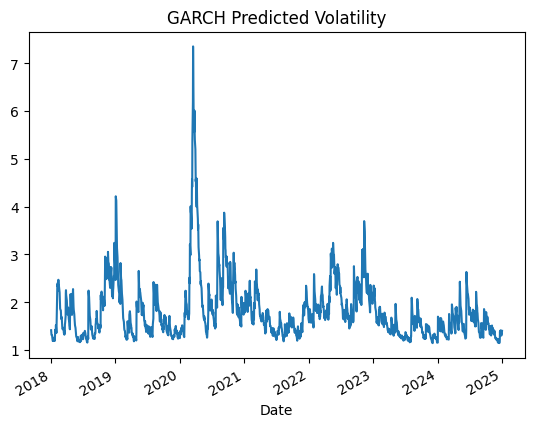

In [22]:
data['GARCH_vol'].plot(title="GARCH Predicted Volatility")
plt.show()

In [23]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data['GARCH_vol'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


c:\Work\garch-lstm-volatility\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.9994 - val_loss: 0.6099
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4656 - val_loss: 0.0634
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2340 - val_loss: 0.0562
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2162 - val_loss: 0.0585
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1823 - val_loss: 0.0524
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1883 - val_loss: 0.0549
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1778 - val_loss: 0.0508
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1717 - val_loss: 0.0497
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1745 - val_loss: 0.0509
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1505 - val_loss: 0.0485
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1512 - val_loss: 0.0473
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1297 - val_loss: 

In [25]:
y_pred = model.predict(X)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


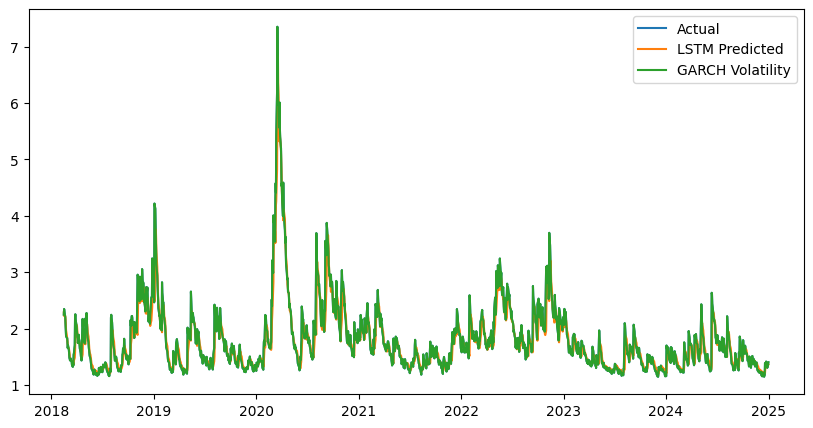

In [26]:
plt.figure(figsize=(10,5))
plt.plot(data.index[seq_length:], y, label="Actual")
plt.plot(data.index[seq_length:], y_pred, label="LSTM Predicted")
plt.plot(data.index[seq_length:], data['GARCH_vol'][seq_length:], label="GARCH Volatility")
plt.legend()
plt.show()

In [27]:
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse, "\nRMSE:", rmse, "\nMAE:", mae)

MSE: 0.041673485784280345 
RMSE: 0.20414084790722395 
MAE: 0.11378639198261774


*OPTIONAL*
To save the model and predictions:

In [28]:
model.save("lstm_model.keras")
print("Model saved as lstm_model.keras")

Model saved as lstm_model.keras


In [29]:
pred_df = pd.DataFrame({
    'Date': data.index[-len(y_pred):],
    'Actual_Volatility': y.flatten(),
    'GARCH_Volatility': data['GARCH_vol'].values[-len(y_pred):],
    'LSTM_Volatility': y_pred.flatten()
})
pred_df.to_csv("predictions.csv", index=False)
print("Predictions saved as predictions.csv")

Predictions saved as predictions.csv
